In [163]:
# Load config
from config import UNetTraining
# from config import UNetTraining
config = UNetTraining.Configuration()

In [89]:
from config import colors
colors = colors.bcolors()

# 0. Imports

In [90]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
# import imgaug as ia
# from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
# from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [91]:
from sys import platform

if platform == "linux" or platform == "linux2":
    path_satellite = "/home/jovyan/work/satellite_data/"
    path_labels = os.getcwd() + "/1_labeled_data/tif/"
    cutouts_path = os.getcwd() + "/2_cutouts/"
elif platform == "darwin":
    path_data = "/Users/leori/Desktop/BA/1_Data/"
    path_satellite = path_data + "2_satellite/"
    path_labels = path_data + "1_labeled_data/tif/"
    cutouts_path = None
elif platform == "win32":
    print("Something went wrong")

In [92]:
# change so that it uses 512 px img instead of 256
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

def UNet(input_shape, input_label_channel, layer_count=64, regularizers = regularizers.l2(0.0001), gaussian_noise=0.1, weight_file = None):
        """ Method to declare the UNet model.

        Args:
            input_shape: tuple(int, int, int, int)
                Shape of the input in the format (batch, height, width, channels).
            input_label_channel: list([int])
                list of index of label channels, used for calculating the number of channels in model output.
            layer_count: (int, optional)
                Count of kernels in first layer. Number of kernels in other layers grows with a fixed factor.
            regularizers: keras.regularizers
                regularizers to use in each layer.
            weight_file: str
                path to the weight file.
        """

        input_img = layers.Input(input_shape[1:], name='Input')
        pp_in_layer  = input_img
#        pp_in_layer = layers.GaussianNoise(gaussian_noise)(input_img)
#        pp_in_layer = layers.BatchNormalization()(pp_in_layer)


        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(pp_in_layer)
        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c1)
        n1 = layers.BatchNormalization()(c1)
        p1 = layers.MaxPooling2D((2, 2))(n1)

        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c2)
        n2 = layers.BatchNormalization()(c2)
        p2 = layers.MaxPooling2D((2, 2))(n2)

        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c3)
        n3 = layers.BatchNormalization()(c3)
        p3 = layers.MaxPooling2D((2, 2))(n3)

        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c4)
        n4 = layers.BatchNormalization()(c4)
        p4 = layers.MaxPooling2D(pool_size=(2, 2))(n4)

        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(p4)
        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(c5)

        u6 = layers.UpSampling2D((2, 2))(c5)
        n6 = layers.BatchNormalization()(u6)
        u6 = layers.concatenate([n6, n4])
        c6 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(u6)
        c6 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c6)

        u7 = layers.UpSampling2D((2, 2))(c6)
        n7 = layers.BatchNormalization()(u7)
        u7 = layers.concatenate([n7, n3])
        c7 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(u7)
        c7 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c7)

        u8 = layers.UpSampling2D((2, 2))(c7)
        n8 = layers.BatchNormalization()(u8)
        u8 = layers.concatenate([n8, n2])
        c8 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(u8)
        c8 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c8)

        u9 = layers.UpSampling2D((2, 2))(c8)
        n9 = layers.BatchNormalization()(u9)
        u9 = layers.concatenate([n9, n1], axis=3)
        c9 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(u9)
        c9 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c9)

        d = layers.Conv2D(len(input_label_channel), (1, 1), activation='sigmoid', kernel_regularizer= regularizers)(c9)

        seg_model = models.Model(inputs=[input_img], outputs=[d])
        if weight_file:
            seg_model.load_weights(weight_file)
        seg_model.summary()
        return seg_model

# 1. Training

### Code from Paper Notebook

#### Get Frames

In [93]:
satellite_cutouts, label_cutouts = [], []

In [ ]:
# 2.372814311058536e-06 x 2.372814310098498e-06
# 2.3728143101288307e-06 x 2.3728143101288515e-06

In [94]:
src_label = rasterio.open(config.filepath_label)
src_satellite = rasterio.open(config.filepath_satellite)

for x in [src_label, src_satellite]:
    print("{} x {}".format(x.width, x.height))
    xRes, yRes = x.res
    print("{} x {}".format(xRes, yRes))

108224 x 107798
2.372814311058536e-06 x 2.372814310098498e-06
108224 x 107798
2.3728143101288307e-06 x 2.3728143101288515e-06


In [95]:
def load_cutout(satellite, label):
    # file =  rasterio.open(complete_filepath)
    filepath_satellite, filepath_label = path_satellite + satellite, path_labels + label
    # check if filepath exists
    if not os.path.isfile(filepath_satellite):
        print(f"{colors.FAIL}1 Failure: File(s) do(es) not exist: {filepath_satellite}{colors.ENDC}") 
        return
    elif not os.path.isfile(filepath_label):
        print(f"{colors.FAIL}1 Failure: File(s) do(es) not exist: {filepath_label}{colors.ENDC}") 
        return
    
    src_label = rasterio.open(filepath_label)
    src_satellite = rasterio.open(filepath_satellite)

    left, top = src_satellite.bounds[0], src_satellite.bounds[3]
    patch_size = config.patch_size[0]
    overlap = config.overlap # similar to previous project: 0.12 * 256 = 30.72
    xRes, yRes = src_satellite.res # or: src.meta['transform'][0], -src.meta['transform'][4]    
    x_cutout_max, y_cutout_max = int(src_satellite.width / patch_size), int(src_satellite.height / patch_size)
    # print("max cutout:", x_cutout_max, y_cutout_max)

    # tmp testing
    x_cutout_max = 3
    y_cutout_max = 3
    # skip first row, because no data there
    # left, top, right, bottom = 29.748021463931796, -26.24839922837354, 29.74923634485858, -26.249614109300325
    # left, top = 29.761112169, -26.262076578039085
    
    for y_cutout in range(y_cutout_max):
        for x_cutout in range(x_cutout_max):

            right  = left + patch_size * xRes 
            bottom = top  - patch_size * yRes

            print("X: {}, Y: {}".format(x_cutout, y_cutout))
            print("Cutout Window: ({}, {}, {}, {})".format(left, top, right, bottom))
            # print("Size of cutout window in px: {} x {}".format(round((right - left) / xRes), round((top - bottom) / yRes)))
            
            cutout_satellite = src_satellite.read(None, window = from_bounds(left, bottom, right, top, src_satellite.transform))
            cutout_label = src_label.read(1, window = from_bounds(left, bottom, right, top, src_label.transform))
            
            show(cutout_satellite)
            show(cutout_label)
            
            print("Shapes:", cutout_satellite.shape, cutout_label.shape)
            satellite_cutouts.append(cutout_satellite)
            label_cutouts.append(cutout_label)

            # adjust cutout window for next iteration (with 32 px overlap to cover trees on the edge)
            # adjust cutout window on the x-axis => move cutout window to the right - the overlap
            left = right - overlap * xRes # use right as a base and move left by the overlap  
            right = left + patch_size * xRes # move patch_size to the right from left # += patch_size * xRes
        # reset the x-axis
        left = src_satellite.bounds[0]
        right  = left + patch_size * xRes
        # adjust cutout window on the y-axis => move cutout window to the bottom
        top = bottom - overlap * yRes
        bottom = top - patch_size * yRes # -= patch_size * yRes

    src_satellite.close()
    src_label.close()

In [96]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds, Window
from rasterio.enums import Resampling
from sys import platform

### Use Coordinates

In [97]:
def calc_coord_lr(filepath, coord_w, coord_n):
    src_img = rasterio.open(filepath)
    xRes, yRes = src_img.res
    # print(xRes, yRes)
    coord_s = coord_n  - config.patch_size[0] * yRes
    coord_e  = coord_w + config.patch_size[1] * xRes 

    cut_win = (coord_w, coord_s, coord_e, coord_n)
    return cut_win

In [98]:
x = 512
# coordinates: left, bottom, right, top
# c_w, c_s, c_e, c_n = 29.748021463931796, -26.249614109300325, 29.74923634485858, -26.24839922837354
# c_w, c_s, c_e, c_n = 29.747940788245252, -26.249690039358253, 29.748548228708646, -26.24908259889486
# c_w, c_s, c_e, c_n = 29.748021463931796, -26.249006668836934, 29.74862890439519, -26.24839922837354

In [141]:
def check_bounds(opened_raster, checked_c_w, checked_c_s, checked_c_e, checked_c_n, ):
    c_w, c_e = opened_raster.bounds[0], opened_raster.bounds[2]
    c_n, c_s = opened_raster.bounds[1], opened_raster.bounds[3]
    print("Bounds:", c_w, c_s, c_e, c_n)
    if checked_c_w < c_w: print(f"{colors.FAIL}The coordinates are too far west ({checked_c_w}). Increase it between {c_w} and {c_e}{colors.ENDC}")
    if checked_c_e > c_e: print(f"{colors.FAIL}The coordinates are too far east ({checked_c_e}). Decrease it between {c_w} and {c_e}{colors.ENDC}")
    if checked_c_n < c_n: print(f"{colors.FAIL}The coordinates are too far north ({checked_c_n}). Decrease it between {c_s} and {c_n}{colors.ENDC}")
    if checked_c_s > c_s: print(f"{colors.FAIL}The coordinates are too far south ({checked_c_s}). Increase it between {c_s} and {c_n}{colors.ENDC}")

In [157]:
# reset to bounds
c_w, c_n = 29.7481, -26.25

Bounds: 29.746877767434313 -26.247113163017453 30.003673223333696 -26.502897800020722
29.7481 -26.250607440463394 29.748707440463395 -26.25
Shape: (3, 256, 256)


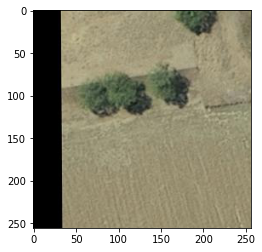

<AxesSubplot:>

In [158]:
sat_lr = calc_coord_lr(config.filepath_satellite, c_w, c_n)
src_satellite = rasterio.open(config.filepath_satellite)
check_bounds(src_satellite, sat_lr[0], sat_lr[1], sat_lr[2], sat_lr[3])
cutout_satellite = src_satellite.read(None, 
    window = from_bounds(c_w, sat_lr[1], sat_lr[2], c_n, src_satellite.transform))
    # window = from_bounds(29.747940788245252, -26.247720603480847, 29.748548228708646, -26.247113163017453, src_satellite.transform))
print(c_w, sat_lr[1], sat_lr[2], c_n)
print("Shape:", cutout_satellite.shape)
show(cutout_satellite)

29.7481 -26.250607440463384 29.748707440463633 -26.25
Shape: (256, 256)


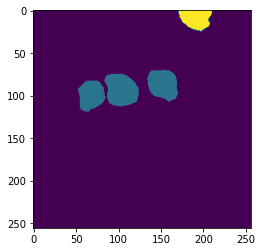

<AxesSubplot:>

In [159]:
src_label = rasterio.open(config.filepath_label)
lab_lr = calc_coord_lr(config.filepath_label, c_w, c_n)
cutout_label = src_label.read(1, 
    window = from_bounds(c_w, lab_lr[1] - 0.0000001, lab_lr[2], c_n, src_label.transform)) 
    # TODO: Had to adjust bottom coordinate, beccause it always rounded the coordinates in a way that the shape was (255,256)
    # window = from_bounds(29.747940788245252, lab_lr[1], lab_lr[2], -26.247113163017453, src_label.transform))
print(c_w, lab_lr[1], lab_lr[2], c_n)
print("Shape:", cutout_label.shape)
show(cutout_label)

In [103]:
cutout_satellite.shape
cutout_label.shape

(3, 255, 256)

(256, 256)

### With Steps (Not Coordinates)

In [164]:
x = 256
start = 2*x
steps = 2*x

512 512 1024


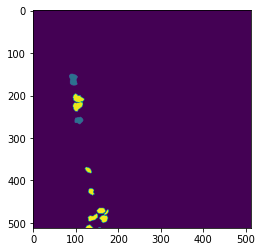

<AxesSubplot:>

In [165]:
cutout_label_rowcol = src_label.read(None, window=Window(start,start,steps,steps))
print(start, steps, start + steps)
show(cutout_label_rowcol)

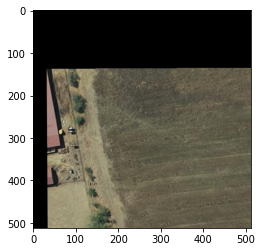

<AxesSubplot:>

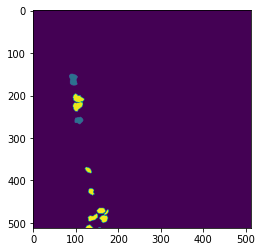

<AxesSubplot:>

In [166]:
# aligned nicht, weil ungleiches origin:
# satellite: (29.746877767434313, -26.247113163017453)
# label:     (29.748224553, -26.248683629)

# different resolution might (!) play a role
# (2.3728143101288307e-06, -2.3728143101288515e-06)
# (2.3728143099711865e-06, -2.3728143123798187e-06)

# img size:
# 108224, 107798
# 106597, 106076

window = Window(start,start,steps,steps)
cutout_satellite_rowcol = src_satellite.read(None, window=window)
show(cutout_satellite_rowcol)

cutout_label_rowcol = src_label.read(None, window=window)
show(cutout_label_rowcol)

In [107]:
# Cutout Window: (29.747409277839783, -26.247113163017453, 29.748016718303177, -26.247720603480847)
# Cutout Window: (29.747940788245252, -26.247113163017453, 29.748548228708646, -26.247720603480847)

X: 0, Y: 0
Cutout Window: (29.746877767, -26.247113163, 29.747485207463633, -26.247720603463385)


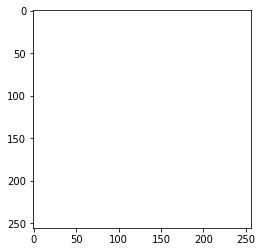

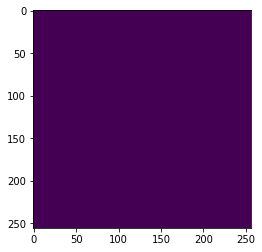

Shapes: (4, 256, 256) (256, 256)
X: 1, Y: 0
Cutout Window: (29.74740927740568, -26.247113163, 29.748016717869312, -26.247720603463385)


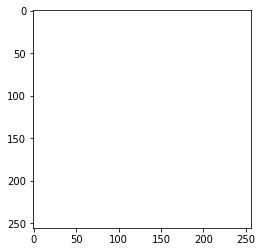

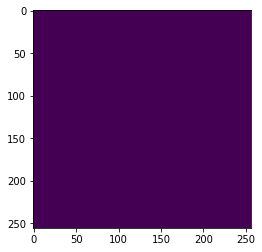

Shapes: (4, 256, 256) (256, 256)
X: 2, Y: 0
Cutout Window: (29.74794078781136, -26.247113163, 29.74854822827499, -26.247720603463385)


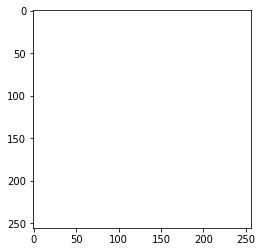

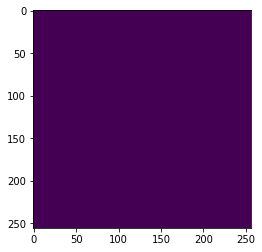

Shapes: (4, 256, 256) (256, 256)
X: 0, Y: 1
Cutout Window: (29.746877767, -26.24779653352131, 29.747485207463633, -26.248403973984693)


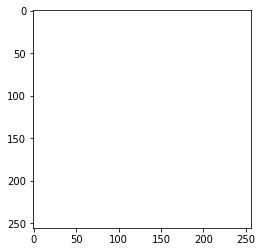

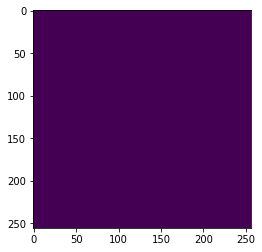

Shapes: (4, 256, 256) (256, 256)
X: 1, Y: 1
Cutout Window: (29.74740927740568, -26.24779653352131, 29.748016717869312, -26.248403973984693)


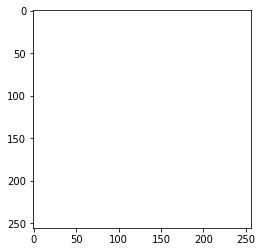

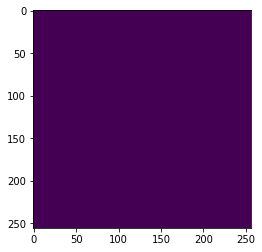

Shapes: (4, 256, 256) (256, 256)
X: 2, Y: 1
Cutout Window: (29.74794078781136, -26.24779653352131, 29.74854822827499, -26.248403973984693)


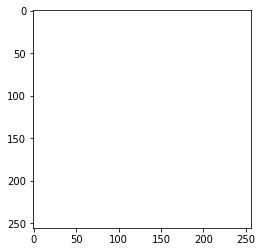

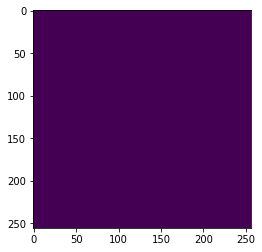

Shapes: (4, 256, 256) (256, 256)
X: 0, Y: 2
Cutout Window: (29.746877767, -26.248479904042618, 29.747485207463633, -26.249087344506002)


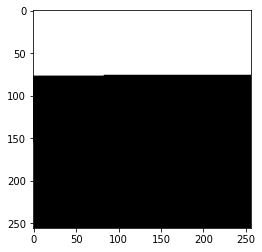

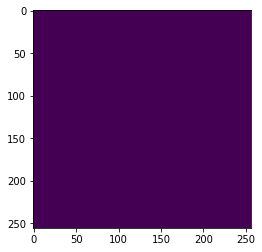

Shapes: (4, 256, 256) (256, 256)
X: 1, Y: 2
Cutout Window: (29.74740927740568, -26.248479904042618, 29.748016717869312, -26.249087344506002)


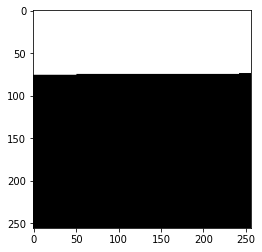

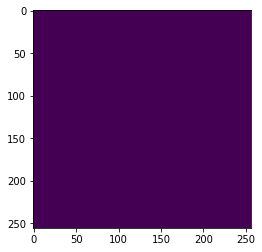

Shapes: (4, 256, 256) (256, 256)
X: 2, Y: 2
Cutout Window: (29.74794078781136, -26.248479904042618, 29.74854822827499, -26.249087344506002)


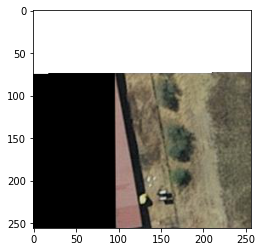

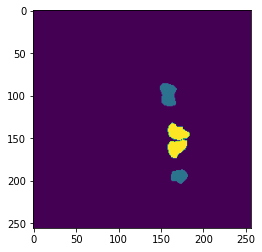

Shapes: (4, 256, 256) (256, 256)


In [172]:
satellite_cutouts = label_cutouts = []
load_cutout("2629BD_2018_exported.tif", "labels-22-02-23.tif")

In [168]:
satellite_cutouts

[array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ...,

In [169]:
label_cutouts

[array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ...,

In [170]:
print(len(label_cutouts))
for x in range(len(label_cutouts)):
    print(label_cutouts[x].shape)

18
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)
(4, 256, 256)
(256, 256)


### With Patchify

In [162]:
satellite_cutouts = label_cutouts = []

In [112]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
# satellite_img = tiff.imread(config.filepath_satellite)
satellite_img = rasterio.open(config.filepath_satellite)
label_img = rasterio.open(config.filepath_label)

In [113]:
%%time
# cutout_satellite = src_satellite.read()
print(cutout_satellite.shape)

(3, 255, 256)
CPU times: user 139 µs, sys: 53 µs, total: 192 µs
Wall time: 154 µs


In [114]:
%%time
# cutout_label = src_label.read(1)
print(cutout_label.shape)

(256, 256)
CPU times: user 143 µs, sys: 61 µs, total: 204 µs
Wall time: 159 µs


In [115]:
print("Satellite Shape:", satellite_img.shape)
print(satellite_img.width)
print(satellite_img.height)
# print("Label Shape:", label_img.shape)
print(satellite_img.name)
print(satellite_img.count)
print("Indexes:", satellite_img.indexes)

Satellite Shape: (107798, 108224)
108224
107798
/Users/leori/Desktop/BA/1_Data/2_satellite/2629BD_2018.tif
3
Indexes: (1, 2, 3)


In [116]:
# from osgeo import gdal
# satellite_img = gdal.Open(config.filepath_satellite)

In [122]:
#This will split the image into small images of shape [3,3]
# patchify(image_to_patch, patch_shape, step=1)

if 0:
    # TODO: 'DatasetReader' object has no attribute 'RasterXSize'
    width, height = satellite_img.RasterXSize, satellite_img.RasterYSize
    patches = patchify(cutout_satellite, (config.patch_size[0], config.patch_size[1], 3), step=config.patch_size[0]-config.overlap)
    # save patches
    print("Patch Shape:", patches.shape)
    # for i in range(4): # patches.shape[0]
    #     for j in range(4): # patches.shape[1]
    #         satellite_cutouts.append(patches[i,j])
    # merge patches into original image: 
    # unpatchify(patches_to_merge, merged_image_size)

In [123]:
#This will split the image into small images of shape [3,3]
# patchify(image_to_patch, patch_shape, step=1)
if 0:
    width, height = satellite_img.RasterXSize, satellite_img.RasterYSize
    print(np.array(satellite_img))
    patches = patchify(
        np.array(satellite_img), 
        (256, 256, 3), 
        step=224)
    # save patches
    print("Patch Shape:", patches.shape)
    # for i in range(4): # height
    #     for j in range(4): # width
    #         satellite_cutouts.append(patches[i,j])
    # merge patches into original image: 
    # unpatchify(patches_to_merge, merged_image_size)

In [125]:
if 0:
    for img in range(satellite_img.shape[0]):
        row = satellite_img[img]
        patches = patchify(row, (config.patch_size[0], config.patch_size[1], 1), step=config.patch_size[0]-config.overlap)
        # save patches
        print("Patch Shape:", patches.shape)
        for i in range(4): # patches.shape[0]
            for j in range(4): # patches.shape[1]
                satellite_cutouts.append(patches[i,j])

In [ ]:
if 0: 
    # Read all images/frames into memory
    frames = []

    all_files = os.listdir(config.base_dir)
    all_files_ndvi = [fn for fn in all_files if fn.startswith(config.ndvi_fn) and fn.endswith(config.image_type)]
    len(all_files_ndvi)
    for i, fn in enumerate(all_files_ndvi):
        # ndvi_img = rasterio.open(os.path.join(config.base_dir, fn))
        # pan_img = rasterio.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.pan_fn)))
        # read_ndvi_img = ndvi_img.read()
        # read_pan_img = pan_img.read()
        # comb_img = np.concatenate((read_ndvi_img, read_pan_img), axis=0)
        # comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
        # annotation_im = Image.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.annotation_fn)))
        # annotation = np.array(annotation_im)
        # weight_im = Image.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.weight_fn)))
        # weight = np.array(weight_im)


        f = FrameInfo(comb_img, annotation) # weight => What does weight do? Used in dataset_generator => maybe use completely different preprocessing altogether3
        
        # TODO: load satellite and label into one frame?


        frames.append(f)

#### Data Generation

In [ ]:
training_frames, validation_frames, testing_frames  = split_dataset(frames, config.frames_json, config.patch_dir)
# training_frames = validation_frames = testing_frames  = list(range(len(frames)))

annotation_channels = config.input_label_channel + config.input_weight_channel
# DataGenerator performs Data Augmentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_generator = DataGenerator(config.input_image_channel, config.patch_size, training_frames, frames, annotation_channels, augmenter = 'iaa').random_generator(config.BATCH_SIZE, normalize = config.normalize)
val_generator = DataGenerator(config.input_image_channel, config.patch_size, validation_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)
test_generator = DataGenerator(config.input_image_channel, config.patch_size, testing_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)

In [ ]:
for _ in range(1):
    train_images, real_label = next(train_generator)
    ann = real_label[:,:,:,0]
    wei = real_label[:,:,:,1]
    #overlay of annotation with boundary to check the accuracy
    #5 images in each row are: pan, ndvi, annotation, weight(boundary), overlay of annotation with weight
    overlay = ann + wei
    overlay = overlay[:,:,:,np.newaxis]
    display_images(np.concatenate((train_images,real_label, overlay), axis = -1))

#### Compile Model

In [ ]:
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'trees_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [ ]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)

In [ ]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

In [ ]:
def reset_cutouts():
    satellite_cutouts = satellite_cutouts = []
    print("Cutouts lists deleted.")
reset_cutouts()

Cutouts lists deleted.


In [ ]:
loss_history = [model.fit(satellite_cutouts, # array of img with shape of [(None, 512, 512, 4)] # train_generator
                         steps_per_epoch=config.MAX_TRAIN_STEPS, 
                         epochs=config.NB_EPOCHS, 
                         validation_data=satellite_cutouts,
                         validation_steps=config.VALID_IMG_COUNT,
                         callbacks=callbacks_list,
                         workers=1,
#                         use_multiprocessing=True # the generator is not very thread safe
                        )]

Epoch 1/200


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 1 input(s), but it received 15 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(1, 511) dtype=uint8>]


# 2. Evaluation

# 3. Prediction

# 9. YT Video: Preview of Test Prediction

In [ ]:
#Load previously saved model
from keras.models import load_model
# model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial118_mitochondria_25epochs.hdf5", compile=False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
# if model is more than 50% sure it is a cell, it returns True, else False
y_pred_thresholded = y_pred > 0.5 

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()